In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

#set font size of labels on matplotlib plots
plt.rc('font', size=16)

#define a custom palette
customPalette = ['#630C3A', '#39C8C6', '#D3500C', '#FFB139']
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=customPalette)

In [2]:
t = 100   #number of timepoints
n = 20    #number of timeseries
bias = 0.1  #bias in random walk

#generate "biased random walk" timeseries
data = pd.DataFrame(np.reshape(np.cumsum(np.random.randn(t,n)+bias,axis=0),(t,n)))
#np.random.randn return values from standard normal distribution
data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.292438,0.355702,0.454346,0.957124,-0.803384,0.779272,1.045204,0.343839,0.004648,1.368747,-1.100645,0.838028,-0.104015,0.078665,-0.591070,0.584717,0.888308,0.653084,0.268374,-0.343957
1,0.698982,1.891823,2.032373,1.090112,-1.771496,0.231942,0.944956,1.020577,0.627117,-0.289538,-0.740312,2.382943,-0.072170,0.188993,-2.557021,1.803074,2.832621,1.874056,0.282083,-1.088318
2,3.341531,1.258364,2.280257,2.481353,-1.753031,0.575058,0.741869,2.445513,1.990392,-0.019436,0.283975,2.206378,0.870081,0.306972,-2.482549,0.048337,4.200146,1.182967,-1.268186,0.593337
3,4.592954,1.296733,2.324064,1.765920,-3.161562,1.659432,-0.386719,4.679823,2.717928,0.626224,0.744520,3.102447,1.376395,0.797142,-2.244471,0.738940,6.173277,1.062355,-1.492709,1.542082
4,3.941278,1.412673,3.967692,3.572706,-2.902557,0.777128,-0.170392,5.969126,3.411931,-0.939401,0.473467,3.928212,2.264257,1.015127,-2.835312,-0.500633,5.519443,1.729276,-2.695887,1.459261


In [3]:
def drift_diffusion_plot(values, upperbound, lowerbound, 
                         upperlabel='', lowerlabel='', 
                         stickybounds=True, **kwargs):
    """
    Creates a formatted drift-diffusion plot for a given timeseries.
    
    Inputs:
       - values: array of values in timeseries
       - upperbound: numeric value of upper bound
       - lowerbound: numeric value of lower bound
       - upperlabel: optional label for upper bound
       - lowerlabel: optional label for lower bound
       - stickybounds: if true, timeseries stops when bound is hit
       - kwargs: https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html
    
    Output:
       - ax: handle to plot axis
    """
    
    #if bounds are sticky, hide timepoints that follow the first bound hit
    if stickybounds:
        #check to see if (and when) a bound was hit
        bound_hits = np.where((values>upperbound) | (values<lowerbound))[0]
        #if a bound was hit, replace subsequent values with NaN
        if len(bound_hits)>0:
            values = values.copy()
            values[bound_hits[0]+1:] = np.nan
    
    #plot timeseries
    ax = plt.gca()
    plt.plot(values, **kwargs)
    
    #format plot
    ax.set_ylim(lowerbound, upperbound)
    ax.set_yticks([lowerbound,upperbound])
    ax.set_yticklabels([lowerlabel,upperlabel])
    ax.axhline(y=np.mean([upperbound, lowerbound]), color='lightgray', zorder=0)
    ax.set_xlim(0,len(values))
    ax.set_xlabel('time')
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    return ax

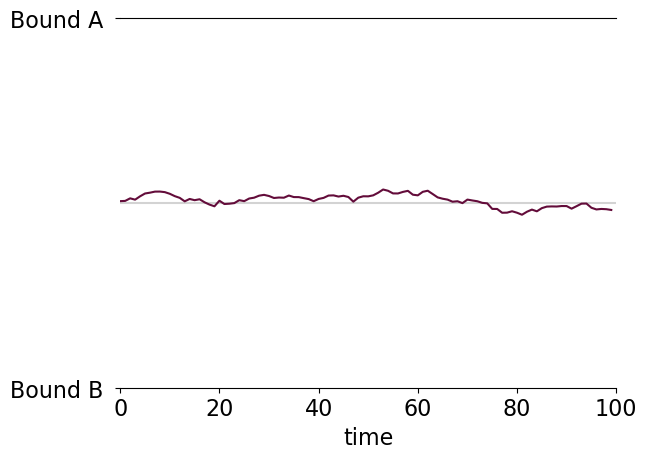

In [4]:
ax = drift_diffusion_plot(data.iloc[:,3], upperbound=100, lowerbound=-100, 
                          upperlabel='Bound A ', lowerlabel='Bound B ', 
                          stickybounds=False)

In [5]:
np.random.randn(t,n)

array([[-0.28098004,  1.17506673,  0.10114854, ...,  1.60418716,
         1.12223142, -1.24459631],
       [ 0.54379828, -1.2607178 , -1.66056243, ..., -2.65443062,
        -1.2747739 ,  0.74393602],
       [ 1.18184663,  1.97998286,  0.65331965, ...,  0.58727345,
         0.22443623,  0.99225651],
       ...,
       [ 0.94620597,  0.18049173, -0.30401866, ..., -0.58674143,
         0.03427149,  0.31145159],
       [ 1.9787742 , -0.56718337, -0.22534385, ..., -0.67616205,
        -1.14397502,  1.0741736 ],
       [-1.17852746,  1.07065441, -0.98182981, ..., -1.53952251,
         0.35325803,  2.18077143]])

In [7]:
import numpy as np

def drift_diffusion_model(v, a, Ter, dt, max_t):
    """
    Simulates a drift-diffusion model for decision making.
    
    Args:
        v (float): Drift rate (decision criterion).
        a (float): Boundary separation (threshold for making a decision).
        Ter (float): Non-decision time (e.g., encoding, motor response, etc.).
        dt (float): Time step for simulation.
        max_t (float): Maximum time allowed for the decision process.
        
    Returns:
        decision (int): 1 if decision is 'A', -1 if decision is 'B'.
        rt (float): Response time.
    """
    t = 0
    x = 0
    
    while t < max_t:
        drift = v * dt + np.random.normal(0, np.sqrt(dt))  # Drift process with noise
        x += drift
        
        if x >= a:
            return 1, t + Ter  # Decision 'A' reached
        elif x <= -a:
            return -1, t + Ter  # Decision 'B' reached
        
        t += dt
    
    return 0, max_t + Ter  # No decision reached within time limit

# Example Usage
v = 0.1  # Drift rate
a = 1.0  # Boundary separation
Ter = 0.2  # Non-decision time
dt = 0.01  # Time step
max_t = 2.0  # Maximum allowed time

decision, rt = drift_diffusion_model(v, a, Ter, dt, max_t)

if decision == 1:
    print("Decision: 'A'")
elif decision == -1:
    print("Decision: 'B'")
else:
    print("No decision reached within time limit")
    
print(f"Response time: {rt} seconds")


Decision: 'B'
Response time: 1.5000000000000009 seconds


12201
11670
65943
15720


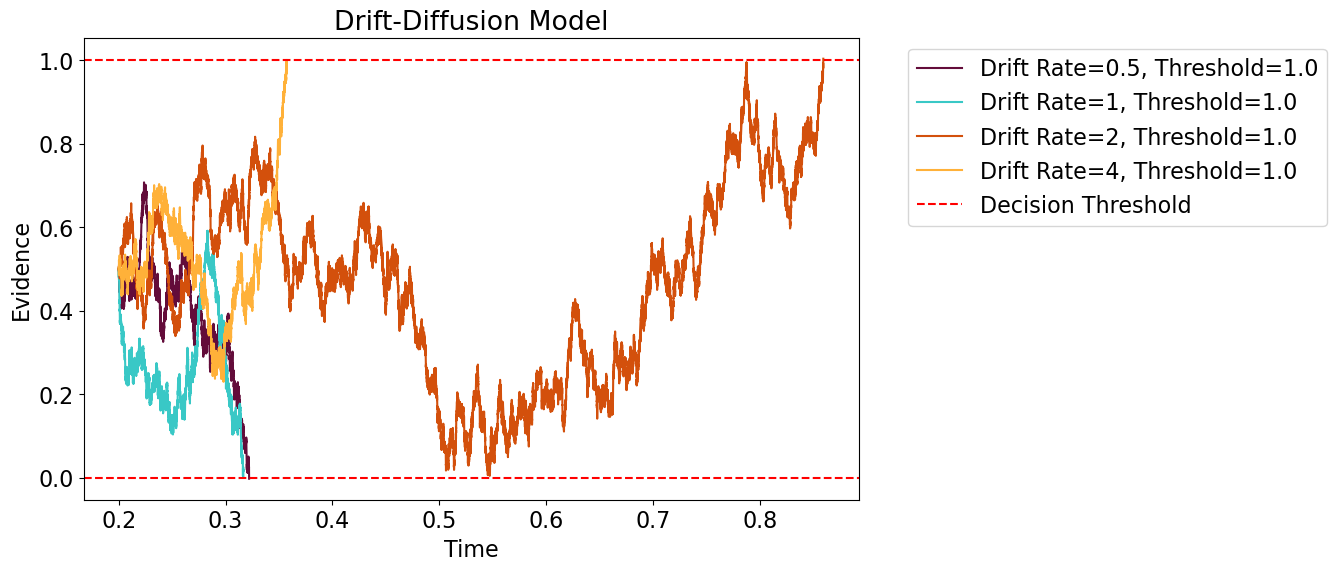

In [57]:
import matplotlib.pyplot as plt

def plot_drift_diffusion(v, a, Ter, dt, max_t, bias):
    t = Ter
    #if you change this you bias the starting point
    x = 0.5*a
    evidence_history= []
    time_points = [t]
    evidence = [x]
    
    
    while t < max_t:
        drift = (v+bias) * dt + np.random.normal(0, np.sqrt(dt))
        x += drift
        
        t += dt
        
        time_points.append(t)
        evidence.append(x)
        
        if x >= a or x <= lower_b:
            break
    
    plt.plot(time_points, evidence, label=f'Drift Rate={v}, Threshold={a}')
    print(len(evidence))

# Example Usage
v_values = [0.5, 1, 2, 4]  # List of different drift rates
a = 1.0
Ter = 0.2
dt = 0.00001
max_t = 2.0
bias = 0
lower_b = 0 

plt.figure(figsize=(10, 6))

for v in v_values:
    plot_drift_diffusion(v, a, Ter, dt, max_t, bias)

plt.xlabel('Time')
plt.ylabel('Evidence')
plt.title('Drift-Diffusion Model')
plt.axhline(a, color='red', linestyle='--', label='Decision Threshold')
plt.axhline(lower_b, color='red', linestyle='--')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [40]:
np.random.normal(0,np.sqrt(dt))

0.6067288436649967

In [31]:
np.sqrt(dt)

0.03162277660168379